In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

## 1) 載入資料集

In [2]:
url = 'https://github.com/1010code/iris-dnn-tensorflow/raw/master/data/Iris.csv'
s=requests.get(url).content
df_data=pd.read_csv(io.StringIO(s.decode('utf-8')))
df_data = df_data.drop(labels=['Id'],axis=1) # 移除Id
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## 2) 手動編碼
處理名目資料 (Nominal variables) - 資料前處理
依據特徵資料的特性，可以選擇手動編碼或自動編碼。

### 使用編碼時機?
進行深度學習時，神經網路只能處理數值資料。因此我們需要將所有非數字型態的特徵進行轉換。

ex:

|  Iris-setosa |  Iris-versicolor | Iris-virginica  |
|:---:|:---:|:---:|
|  1 | 2  | 3  |

In [3]:
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

#將編碼後的label map存至df_data['Species']中。
df_data['Class'] = df_data['Species'].map(label_map)

In [4]:
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Class
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


## 3) 檢查缺失值
使用 numpy 所提供的函式來檢查是否有 NA 缺失值，假設有缺失值使用dropna()來移除。使用的時機在於當只有少量的缺失值適用，若遇到有大量缺失值的情況，或是本身的資料量就很少的情況下建議可以透過機器學習的方法補值來預測缺失值。

```python
# 移除缺失值
train=train.dropna()
```

In [5]:
X = df_data.drop(labels=['Species','Class'],axis=1).values # 移除Species (因為字母不參與訓練)
# checked missing data
print("checked missing data(NAN mount):",len(np.where(np.isnan(X))[0]))

checked missing data(NAN mount): 0


## 4) 切割訓練集與測試集

In [6]:
from sklearn.model_selection import train_test_split
X=df_data.drop(labels=['Class','Species'],axis=1)
y=df_data['Class']
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=.3 , random_state=42)

In [7]:
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (105, 4)
Testing data shape: (45, 4)


In [16]:
X_train

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Class,Predict
81,5.5,2.4,3.7,1.0,1,1
133,6.3,2.8,5.1,1.5,2,2
137,6.4,3.1,5.5,1.8,2,2
75,6.6,3.0,4.4,1.4,1,1
109,7.2,3.6,6.1,2.5,2,2
...,...,...,...,...,...,...
71,6.1,2.8,4.0,1.3,1,1
106,4.9,2.5,4.5,1.7,2,2
14,5.8,4.0,1.2,0.2,0,0
92,5.8,2.6,4.0,1.2,1,1


## 隨機森林(分類器)
隨機森林其實就是進階版的決策樹。隨機森林是使用 Bagging + 隨機特徵的技術所產生出來的 Ensemble learning 演算法。

Parameters:
- n_estimators: 森林中樹木的數量，預設=100。
- max_features: 劃分時考慮的最大特徵數，預設auto。
- criterion: 亂度的評估標準，gini/entropy。預設為gini。
- max_depth: 樹的最大深度。
- splitter: 特徵劃分點選擇標準，best/random。預設為best。
- random_state: 亂數種子，確保每次訓練結果都一樣，splitter=random 才有用。
- min_samples_split: 至少有多少資料才能再分
- min_samples_leaf: 分完至少有多少資料才能分

Attributes:
- feature_importances_: 查詢模型特徵的重要程度。

Methods:
- fit: 放入X、y進行模型擬合。
- predict: 預測並回傳預測類別。
- score: 預測成功的比例。
- predict_proba: 預測每個類別的機率值。
- get_depth: 取得樹的深度。

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 建立RandomForest模型
randomForestModel = RandomForestClassifier(n_estimators=100, criterion = 'gini')
# 使用訓練資料訓練模型
randomForestModel.fit(X_train, y_train)
# 使用訓練資料預測分類
predicted = randomForestModel.predict(X_train)

## 使用Score評估模型

In [9]:
# 預測成功的比例
print('訓練集: ',randomForestModel.score(X_train,y_train))
print('測試集: ',randomForestModel.score(X_test,y_test))

訓練集:  1.0
測試集:  1.0


## 特徵重要程度

In [10]:
print('特徵重要程度: ',randomForestModel.feature_importances_)

特徵重要程度:  [0.09403523 0.03489081 0.43202901 0.43904496]


## 真實分類

In [11]:
# 建立訓練集的 DataFrme
df_train=pd.DataFrame(X_train)
df_train['Class']=y_train
# 建立測試集的 DataFrme
df_test=pd.DataFrame(X_test)
df_test['Class']=y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


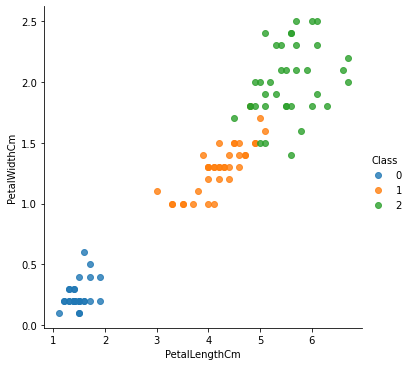

In [12]:
sns.lmplot("PetalLengthCm", "PetalWidthCm", hue='Class', data=df_train, fit_reg=False)

## 隨機森林 (訓練集)預測結果

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


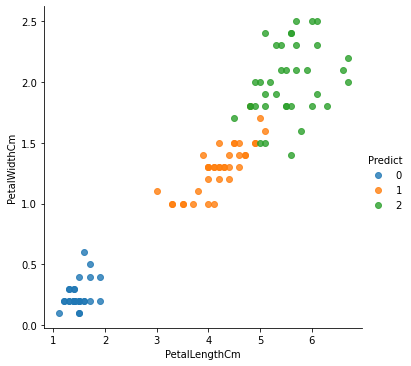

In [13]:
df_train['Predict']=predicted
sns.lmplot("PetalLengthCm", "PetalWidthCm", data=df_train, hue="Predict", fit_reg=False)
plt.show()

## 繪製森林中的每一棵樹

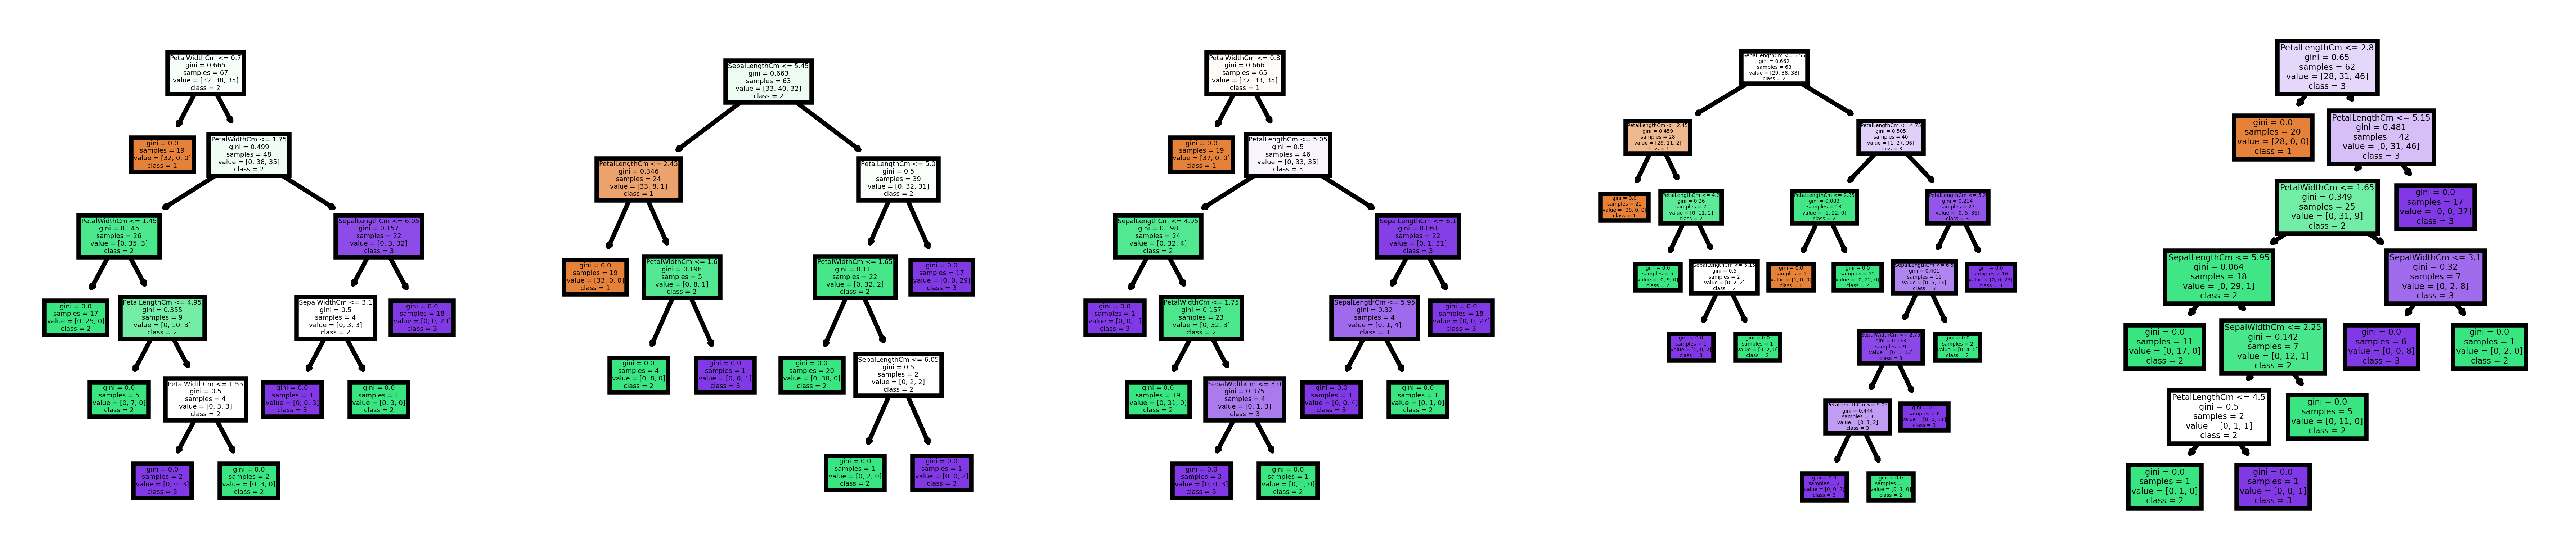

In [14]:
from sklearn import tree
featureName=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
className=['1','2','3']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(randomForestModel.estimators_[index],
                   feature_names = featureName, 
                   class_names=className,
                   filled = True,
                   ax = axes[index]);